# Unveiling Human Emotions through Advanced Deep Learning Techniques

In [1]:
#import paskages
import os
import numpy as np
import pandas as pd
import datetime

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks

from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from keras.optimizers import Adam
from keras import regularizers
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping
from keras.utils import plot_model


In [2]:
# Constants
TRAIN_DATA_PATH = 'Dataset/train'
TEST_DATA_PATH = 'Dataset/test'
IMAGE_SIZE = (48, 48)
BATCH_SIZE = 64
NUM_CLASSES = 7
EPOCHS = 100

In [3]:
# Data exploration
train_counts = {expression: len(os.listdir(os.path.join(TRAIN_DATA_PATH, expression))) 
                for expression in os.listdir(TRAIN_DATA_PATH)}
train_counts_df = pd.DataFrame(train_counts, index=['train'])


In [4]:
test_counts = {expression: len(os.listdir(os.path.join(TEST_DATA_PATH, expression))) 
               for expression in os.listdir(TEST_DATA_PATH)}
test_counts_df = pd.DataFrame(test_counts, index=['test'])


In [5]:
print("Number of images in training set:")
print(train_counts_df)

Number of images in training set:
       angry  disgusted  fearful  happy  neutral   sad  surprised
train   3995        436     4097   7215     4965  4830       3171


In [6]:
print("\nNumber of images in test set:")
print(test_counts_df)


Number of images in test set:
      angry  disgusted  fearful  happy  neutral   sad  surprised
test    958        111     1024   1774     1233  1247        831


In [7]:
print("\nNumber of images in test set:")
print(test_counts_df)


Number of images in test set:
      angry  disgusted  fearful  happy  neutral   sad  surprised
test    958        111     1024   1774     1233  1247        831


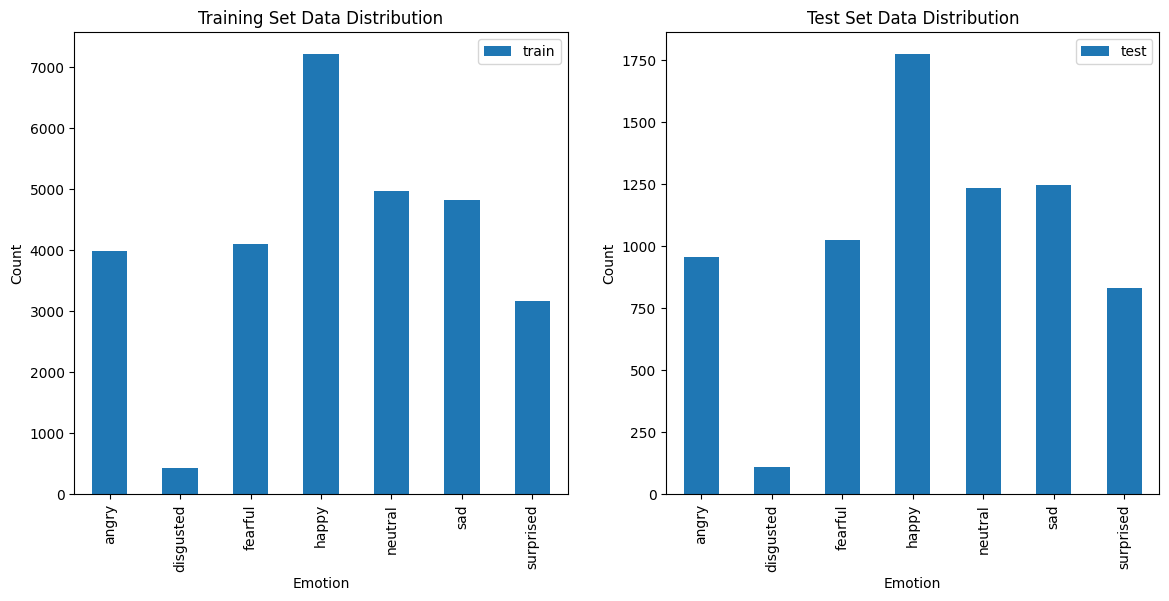

In [8]:

# Plotting data distribution
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
train_counts_df.transpose().plot(kind='bar', ax=plt.gca())
plt.title('Training Set Data Distribution')
plt.xlabel('Emotion')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
test_counts_df.transpose().plot(kind='bar', ax=plt.gca())
plt.title('Test Set Data Distribution')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.show()

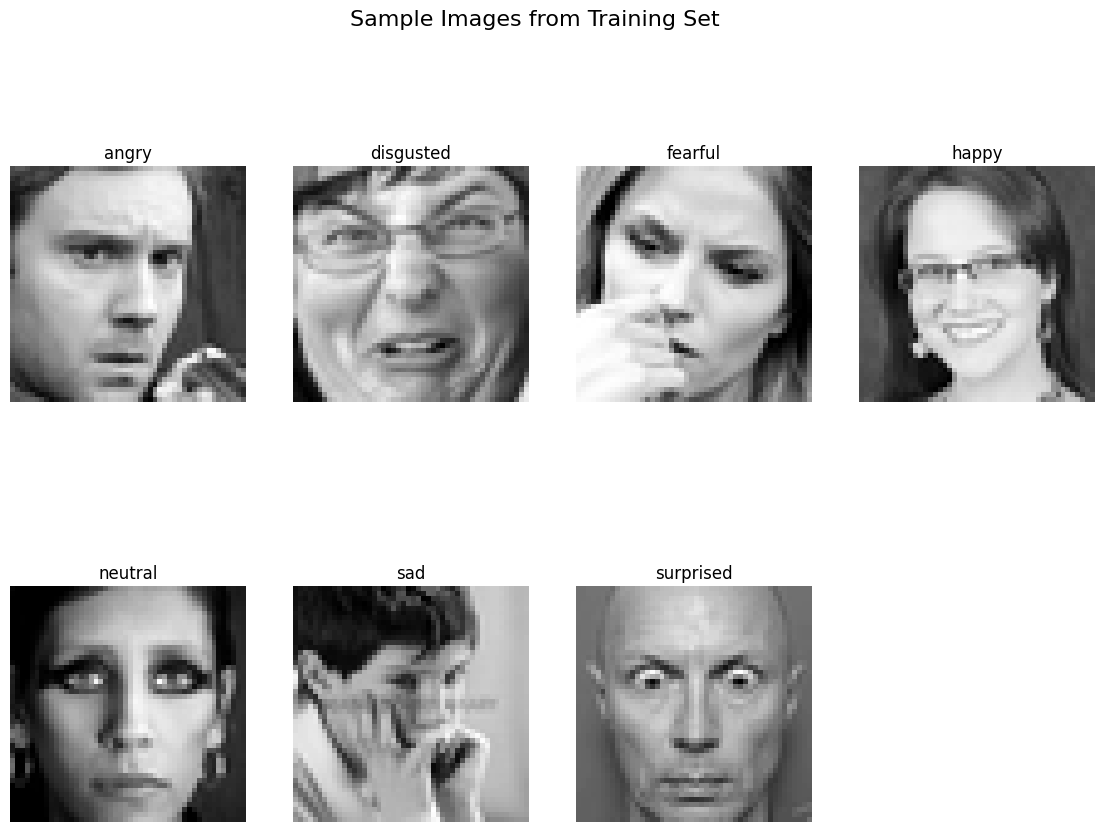

In [9]:
# Plotting sample images from each class
plt.figure(figsize=(14, 10))
for i, expression in enumerate(os.listdir(TRAIN_DATA_PATH), 1):
    img_path = os.path.join(TRAIN_DATA_PATH, expression, os.listdir(os.path.join(TRAIN_DATA_PATH, expression))[0])
    img = plt.imread(img_path)
    plt.subplot(2, 4, i)
    plt.imshow(img, cmap='gray')
    plt.title(expression)
    plt.axis('off')
plt.suptitle('Sample Images from Training Set', fontsize=16)
plt.show()

In [10]:
# Loading and analyzing a sample image to understand pixel intensity distribution
sample_img_path = os.path.join(TRAIN_DATA_PATH, 'happy', os.listdir(os.path.join(TRAIN_DATA_PATH, 'happy'))[0])
sample_img = plt.imread(sample_img_path)


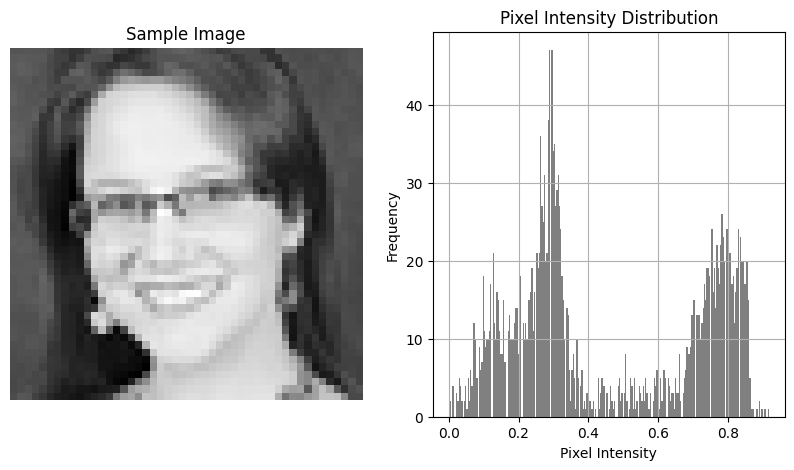

In [11]:

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(sample_img, cmap='gray')
plt.title('Sample Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.hist(sample_img.ravel(), bins=256, color='gray')
plt.title('Pixel Intensity Distribution')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [12]:
# Data preprocessing and augmentation
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, zoom_range=0.3, horizontal_flip=True)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)


In [13]:
#generator

train_generator = train_datagen.flow_from_directory(
    TRAIN_DATA_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=True)

test_generator = test_datagen.flow_from_directory(
    TEST_DATA_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=False)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# # # Build Modeling

In [14]:
# Model creation
def create_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.BatchNormalization(),
        
        layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.BatchNormalization(),
        
        layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.BatchNormalization(),
        
        layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.BatchNormalization(),
        
        layers.Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.BatchNormalization(),
        
        layers.Flatten(),
        layers.Dense(1024, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        
        layers.Dense(num_classes, activation='softmax')
    ])
    
    optimizer = optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [15]:
# Create and compile the model
model = create_model(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 1), num_classes=NUM_CLASSES)


In [16]:
#print summary 
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 23, 23, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 10, 10, 64)        0         
 g2D)                                                            
                                                        

In [17]:
# Callbacks
log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
checkpoint = callbacks.ModelCheckpoint('model_detect_emotional.h5', save_best_only=True, verbose=1, monitor='val_loss')
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_delta=0.00001, verbose=1)
tensorboard_callback = callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = callbacks.CSVLogger('training.log')
callbacks_list = [checkpoint, reduce_lr, csv_logger, tensorboard_callback, early_stopping]


In [18]:
# Model training
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=EPOCHS,
    validation_data=test_generator,
    validation_steps=test_generator.n // test_generator.batch_size,
    callbacks=callbacks_list)

Epoch 1/100
448/448 [==============================] - ETA: 0s - loss: 2.0739 - accuracy: 0.2757
Epoch 1: val_loss improved from inf to 1.85585, saving model to model_detect_emotional.h5


C:\Users\Charu Gupta\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


448/448 [==============================] - 196s 433ms/step - loss: 2.0739 - accuracy: 0.2757 - val_loss: 1.8559 - val_accuracy: 0.2979 - lr: 1.0000e-04
Epoch 2/100
448/448 [==============================] - ETA: 0s - loss: 1.7898 - accuracy: 0.3434
Epoch 2: val_loss improved from 1.85585 to 1.63832, saving model to model_detect_emotional.h5
448/448 [==============================] - 83s 185ms/step - loss: 1.7898 - accuracy: 0.3434 - val_loss: 1.6383 - val_accuracy: 0.3841 - lr: 1.0000e-04
Epoch 3/100
448/448 [==============================] - ETA: 0s - loss: 1.6747 - accuracy: 0.3828
Epoch 3: val_loss improved from 1.63832 to 1.54766, saving model to model_detect_emotional.h5
448/448 [==============================] - 86s 193ms/step - loss: 1.6747 - accuracy: 0.3828 - val_loss: 1.5477 - val_accuracy: 0.4109 - lr: 1.0000e-04
Epoch 4/100
448/448 [==============================] - ETA: 0s - loss: 1.6044 - accuracy: 0.4048
Epoch 4: val_loss did not improve from 1.54766
448/448 [===========

# # # Evaluation

In [19]:
evaluation = model.evaluate(test_generator)
print(f"\nTest Accuracy: {evaluation[1] * 100:.2f}%")


  1/113 [..............................] - ETA: 7s - loss: 0.9932 - accuracy: 0.5625

113/113 [==============================] - 3s 29ms/step - loss: 1.2009 - accuracy: 0.5711

Test Accuracy: 57.11%


In [20]:
# Confusion matrix
y_pred = np.argmax(model.predict(test_generator), axis=1)
y_true = test_generator.classes



113/113 [==============================] - 3s 28ms/step


In [21]:
conf_matrix = confusion_matrix(test_generator.classes, y_pred)


In [22]:
# Classification report
class_labels = list(test_generator.class_indices.keys())
print("\nClassification Report:\n", classification_report(test_generator.classes, y_pred, target_names=class_labels))



Classification Report:
               precision    recall  f1-score   support

       angry       0.46      0.51      0.48       958
   disgusted       0.67      0.38      0.48       111
     fearful       0.40      0.39      0.40      1024
       happy       0.81      0.76      0.79      1774
     neutral       0.53      0.51      0.52      1233
         sad       0.45      0.48      0.47      1247
   surprised       0.68      0.71      0.69       831

    accuracy                           0.57      7178
   macro avg       0.57      0.53      0.55      7178
weighted avg       0.58      0.57      0.57      7178



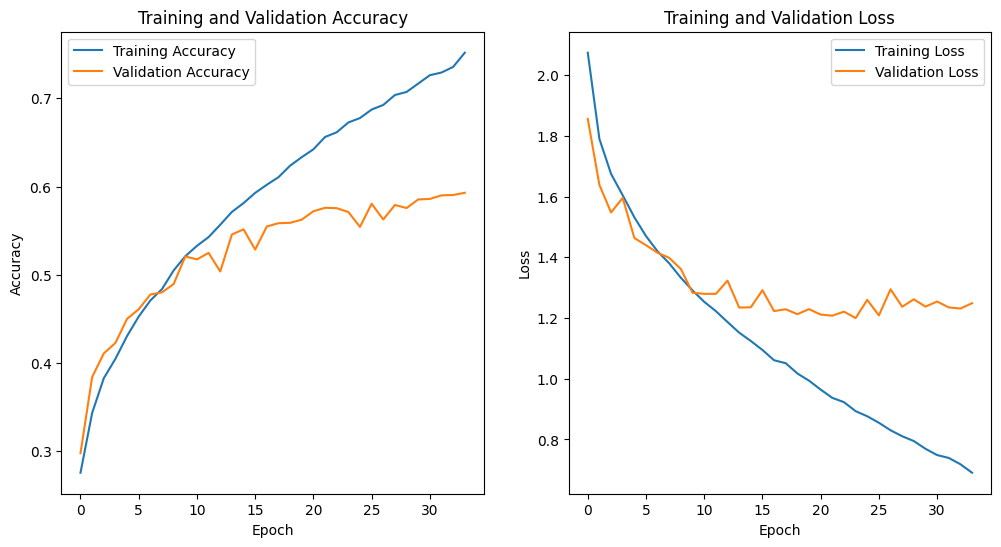

In [23]:
# Plotting training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

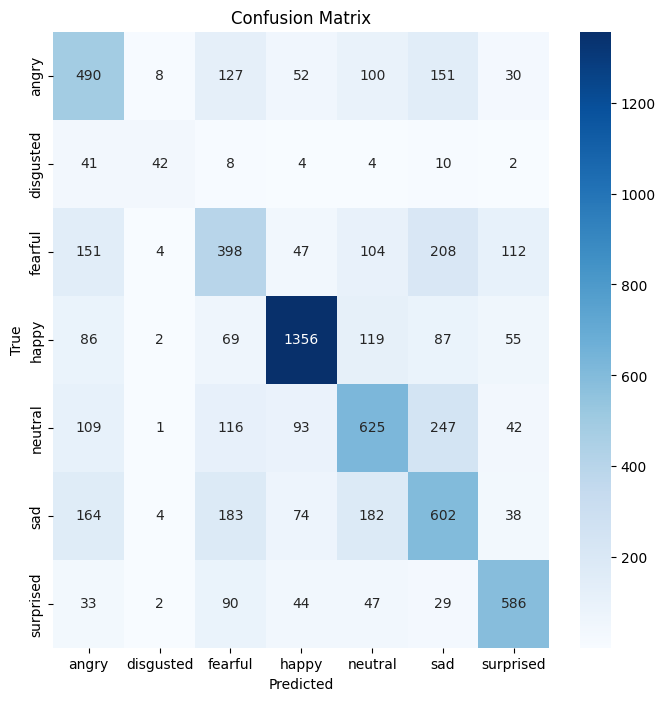

In [24]:
# Confusion matrix visualization
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

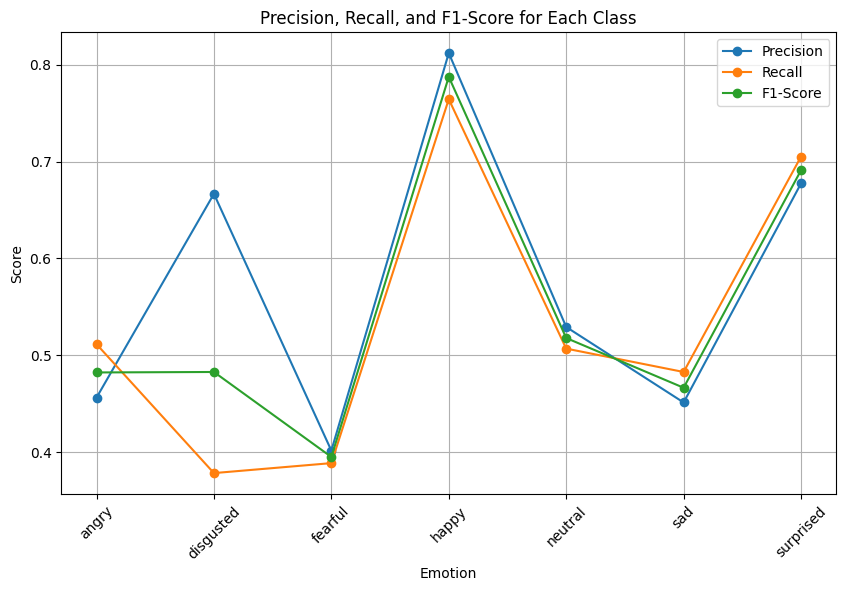

In [25]:

# Plotting precision, recall, and F1-score for each class
metrics = classification_report(y_true, y_pred, target_names=class_labels, output_dict=True)
precision = [metrics[label]['precision'] for label in class_labels]
recall = [metrics[label]['recall'] for label in class_labels]
f1_score = [metrics[label]['f1-score'] for label in class_labels]

plt.figure(figsize=(10, 6))
plt.plot(class_labels, precision, marker='o', label='Precision')
plt.plot(class_labels, recall, marker='o', label='Recall')
plt.plot(class_labels, f1_score, marker='o', label='F1-Score')
plt.title('Precision, Recall, and F1-Score for Each Class')
plt.xlabel('Emotion')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

In [28]:
#save model
model_path = 'emotion_detection_model.h5'

# Save the model
model.save(model_path)